<a href="https://colab.research.google.com/github/nasreenpmohsin/17FlowerCalssification-VGG/blob/main/17FlowerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Intalling Pytorch libraries

In [1]:
!pip3 install torch torchvision

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # for file editing
import shutil # for console commands
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import math
np.random.seed(111)


Downloading and extraction of 17 Flower classification data from the VGG lab group

In [3]:
import tarfile
#import urllib
import urllib.request
def download(filename, source_url, work_directory):
    if not os.path.exists(work_directory): #check if the folder exists; if not make dir
        os.mkdir(work_directory)
    filepath = os.path.join(work_directory, filename)
    if not os.path.exists(filepath): # check if file exists; if not, download
        print("Downloading file, Please wait...")
        filepath, _ = urllib.request.urlretrieve(source_url + filename, # this is a function to download files
                                                 filepath)
        statinfo = os.stat(filepath)
        print(('Succesfully downloaded', filename, statinfo.st_size, 'bytes.'))
        untar(filepath,work_directory)
    return filepath
# extract function
def untar(fname,path="17category-flowers"): #untarring the archive
    tar = tarfile.open(fname)
    tar.extractall(path="17category-flowers", members=jpg_files(tar))
    tar.close()
    if path is "":
        print("File Extracted in Current Directory")
    else:
        print("File Extracted in to ",  path)
#only extract jpg files
def jpg_files(members):
    for tarinfo in members:
        if os.path.splitext(tarinfo.name)[1] == ".jpg":
            yield tarinfo

In [4]:
download("17flowers.tgz", "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/","17category-flowers")

'17category-flowers/17flowers.tgz'

In [5]:
os.listdir("/content/17category-flowers")

['17flowers.tgz', 'jpg']

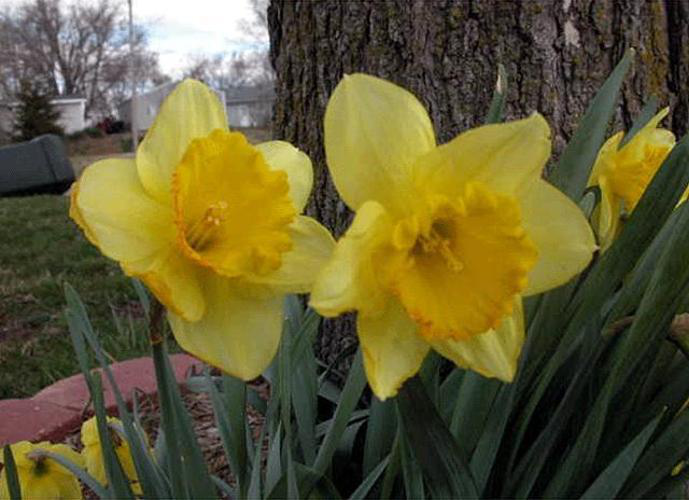

In [6]:
from PIL import Image #show one example of image
Image.open("/content/17category-flowers/jpg/image_0001.jpg")

In [7]:
#all images are loaded as np arrays
images=[]
labels=[]
total=1361
width=224
height=224
j=1
for i in range(1, total): 
    fname="/content/17category-flowers/jpg/image_"    
    fpath = os.path.join(fname + str(i).zfill(4) + ".jpg")
    img=Image.open(fpath).resize((width,height)) # resize to width x height for modelling
    img = np.asarray(img, dtype='float32')
    images.append(img)
    labels.append(j) #labels are created as [1,2,3...,17]
    if i%80==0: j+=1


In [8]:
"""print(len(images[0]))
print(len(images[1]))
print(len(images[2]))
print(len(images[3]))"""
images = np.asarray(images)#.reshape(1360,width,height,3) # all of the images are converted to np array of (1360,width,height,3)
labels = np.asarray(labels).reshape(1360,1) # labels are also converted to (1360,1)
images.shape
#labels.shape

(1360, 1)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


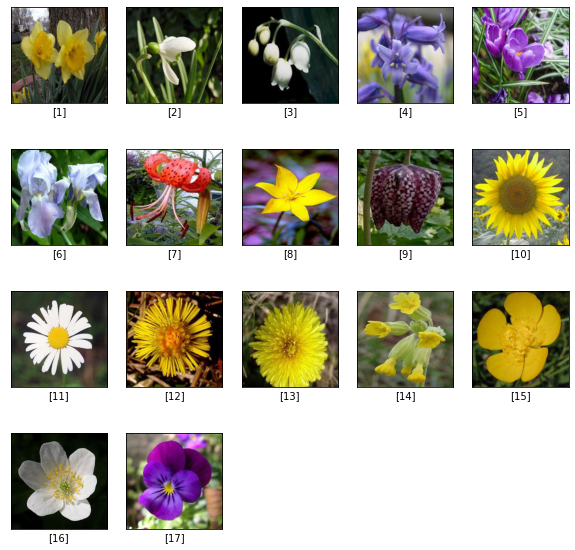

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) # plot 1 image from each category
for i in range(17):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i*80]/255, cmap=plt.cm.binary)
    plt.xlabel(labels[i*80])

In [10]:
# split data into training and test
from sklearn.model_selection import train_test_split 
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size = 0.8, random_state =  42)#,stratify=labels)
# split training data into training and validiation set
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size = 0.25, random_state =  42)#,stratify=train_labels)
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(816, 224, 224, 3)
(272, 224, 224, 3)
(272, 224, 224, 3)


In [11]:
import torchvision.transforms as transforms
    # Load all the images
transformation = { 
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.ToPILImage(),
        transforms.Resize(224),
        # Randomly augment the image data
            # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
        'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.ToPILImage(),
        transforms.Resize(224),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),

  }

In [12]:
import torch
global CUDA 
CUDA= torch.cuda.is_available() # if GPU is available in colab

import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision.models as models
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, TensorDataset
import torchvision
#import torchvision.transforms as transforms
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)


torch_train_images = torch.from_numpy(train_images)
torch_train_labels = torch.from_numpy(train_labels)
"""
print(torch_train_images.size())
torch_train_images=torch.reshape(torch_train_images,(-1,3,224,224))
print(torch_train_images.size())
tf1=transforms.ToTensor()
torch_train_images=tf1(train_images[0])
print(torch_train_images.size())
"""
torch_val_images = torch.from_numpy(val_images)
torch_val_labels = torch.from_numpy(val_labels)

# create feature and targets tensor for test set.
torch_test_images = torch.from_numpy(test_images)
torch_test_labels = torch.from_numpy(test_labels)

#print(test_labels)


In [13]:
class CustomTensorDataset(Dataset):
 
    '''
    A simple loading dataset - loads the tensor that are passed in input. This is the same as
    torch.utils.data.TensorDataset except that you can add transformations to your data and target tensor.
    Target tensor can also be None, in which case it is not returned.
    '''
 
    def __init__(self, data_tensor, target_tensor=None, transforms=None, target_transforms=None):
        #if target_tensor is not None:
        #    assert data_tensor.size(0) == target_tensor.size(0)
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor
 
        if transforms is None:
            transforms = []
        if target_transforms is None:
            target_transforms = []
 
        if not isinstance(transforms, list):
            transforms = [transforms]
        if not isinstance(target_transforms, list):
            target_transforms = [target_transforms]
 
        self.transforms = transforms
        self.target_transforms = target_transforms
 
    def __getitem__(self, index):
 
        data_tensor = self.data_tensor[index]
        for transform in self.transforms:
            data_tensor = transform(data_tensor)
 
        if self.target_tensor is None:
            return data_tensor
 
        target_tensor = self.target_tensor[index][0]-1
        if self.target_transforms:
          for transform in self.target_transforms:
              target_tensor = transform(target_tensor)
 
        return data_tensor, target_tensor
 
    def __len__(self):
        return len(self.data_tensor)

In [14]:
# Pytorch train, val and test sets
print(train_labels[0])
train_ds = CustomTensorDataset(train_images,train_labels,transforms=transformation['train'])
val_ds = CustomTensorDataset(val_images,val_labels,transforms=transformation['test'])
test_ds = CustomTensorDataset(test_images,test_labels,transforms=transformation['test'])

# data loader
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
BATCH_SIZE_train = 70
BATCH_SIZE_test=10
dataloader_train = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE_train, shuffle = True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(val_ds, batch_size = BATCH_SIZE_test, shuffle = True, num_workers=2)
dataloader_test = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE_test, shuffle = False,num_workers=2)
dataloaders = {'train': dataloader_train, 'test': dataloader_test, 'val':dataloader_val}

[9]


In [15]:
# Using Pretrained CNN model ResNet18
class PreTrainedResNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedResNet, self).__init__()
    
    #self.net=models.vgg13(pretrained=True)
    self.net = models.resnet18(pretrained=True)

    if feature_extracting:
      for param in self.net.parameters():
          param.requires_grad = False
    
    num_feats = self.net.fc.in_features
    
    self.net.fc =  nn.Linear(num_feats,num_classes)

  def forward(self, x):
    x = self.net.forward(x)
    return x


In [16]:
# function for train the model
def train(model, optimizer, criterion, epoch, num_epochs):
  model.train()
  epoch_loss = 0.0
  epoch_acc = 0.0
  
  for batch_idx, (images, labels) in enumerate(dataloaders['train']):
    optimizer.zero_grad()
    if CUDA:  
      images, labels = images.cuda(), labels.cuda()
    
    #print(images.shape)
    #print(labels.shape)
    outputs = model.forward(images)
    
    #print(labels[0])
    loss = criterion(outputs, labels)#.squeeze(1))
    _, preds = torch.max(outputs.data, 1)
    loss.backward() # backward propagation
    optimizer.step() # update gradients and weights
    #preds=torch.transpose(preds,0,1)
    """
    print(preds[0:5])
    print(labels[0:5])
    print(torch.sum(preds == labels).item())
    input()"""
    epoch_loss += loss.item()
    epoch_acc += torch.sum(preds == labels).item() 
  epoch_loss /= dataset_sizes['train']
  epoch_acc /= dataset_sizes['train']
  
  print('TRAINING Epoch %d/%d Loss %.4f Accuracy %.4f' % (epoch, num_epochs, epoch_loss, epoch_acc))

  return epoch_loss, epoch_acc


In [17]:
import sklearn.metrics as metric
# function for evaluating the model
def test(model, criterion, repeats=2):
  model.eval()
  
  test_loss = 0.0
  test_acc = 0.0
  f1_score = 0.0
  f1_score_w = 0.0
  conf_mat = np.zeros([len(class_names),len(class_names)])
  with torch.no_grad():
    for itr in range(repeats):
      for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        #move to GPU
        if CUDA:
          images, labels = images.cuda(), labels.cuda()

        #forward
        outputs = model.forward(images)
        _, preds = torch.max(outputs.data, 1)

        predlabels = preds.cpu().numpy()
        labels_num = labels.cpu().numpy()
        for ind,label in enumerate(labels_num):
          conf_mat[label,predlabels[ind]] = conf_mat[label,predlabels[ind]] + 1
        

        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)

        test_loss += loss.item()
        test_acc += torch.sum(preds == labels).item()
          
        f1_score += metric.f1_score(labels_num, predlabels,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], average='weighted', zero_division='warn')
        f1_score_w += metric.f1_score(labels_num, predlabels,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], average='macro', zero_division='warn')

    test_loss /= (dataset_sizes['test']*repeats)
    test_acc /= (dataset_sizes['test']*repeats)
    f1_score /= (dataset_sizes['test']*repeats)


    print('Test Loss: %.4f Test Accuracy %.4f Weighted: %.4f Macro: %.4f' % (test_loss, test_acc, f1_score_w, f1_score))
    return test_loss, test_acc, conf_mat

# function for testing the validation dataset during training
def val(model, criterion, repeats=2):
  model.eval()
  
  test_loss = 0.0
  test_acc = 0.0
  
  with torch.no_grad():
    for itr in range(repeats):
      for batch_idx, (images, labels) in enumerate(dataloaders['val']):
        #move to GPU
        if CUDA:
          images, labels = images.cuda(), labels.cuda()

        #forward
        outputs = model.forward(images)

        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)

        test_loss += loss.item()
        test_acc += torch.sum(preds == labels).item()

    test_loss /= (dataset_sizes['val']*repeats)
    test_acc /= (dataset_sizes['val']*repeats)

    print('Val Loss: %.4f Val Accuracy %.4f' % (test_loss, test_acc))

    return test_loss, test_acc

In [18]:

NUM_EPOCHS = 30
LEARNING_RATE = 0.001 
RESNET_LAST_ONLY = False #Fine tunes only the last layer. Set to False to fine tune entire network

dataset_size_train = len(train_ds)
print(dataset_size_train)
dataset_size_val = len(val_ds)
print(dataset_size_val)
dataset_size_test = len(test_ds)
print(dataset_size_test)

dataset_sizes = {'train': dataset_size_train, 'test': dataset_size_test, 'val':dataset_size_val}


class_names = [ str(x) for x in range(1,18)]
print(class_names)

#Initialize the model
model = PreTrainedResNet(len(class_names), RESNET_LAST_ONLY)
if CUDA:
    model = model.cuda()
else:
    model = model

#Setting the optimizer and loss criterion
#optimizer= optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=1e-3, betas=(0.9, 0.999))
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9 , weight_decay=1e-3)

weightlist = [1]*17 # Assuing the class dsitrubution are nearly uniform
weightlist = torch.Tensor(weightlist)
if CUDA:
  weightlist = weightlist.cuda()
criterion = nn.CrossEntropyLoss(weight = weightlist)

train_loss_list =[]
train_acc_list = []
val_loss_list =[]
val_acc_list = []

#Begin Train
for epoch in range(NUM_EPOCHS):
  t1,t2 = train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  train_loss_list.append(t1)
  train_acc_list.append(t2)
  if (epoch+1) % 5 == 0:
    t1,t2 = val(model, criterion)
    val_loss_list.append(t1)
    val_acc_list.append(t2)
  
print("Finished Training")
print("-"*10)

816
272
272
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17']
TRAINING Epoch 1/30 Loss 0.0414 Accuracy 0.1164
TRAINING Epoch 2/30 Loss 0.0332 Accuracy 0.3689
TRAINING Epoch 3/30 Loss 0.0250 Accuracy 0.6703
TRAINING Epoch 4/30 Loss 0.0184 Accuracy 0.8223
TRAINING Epoch 5/30 Loss 0.0138 Accuracy 0.8848
Val Loss: 0.0963 Val Accuracy 0.8382
TRAINING Epoch 6/30 Loss 0.0109 Accuracy 0.9044
TRAINING Epoch 7/30 Loss 0.0084 Accuracy 0.9350
TRAINING Epoch 8/30 Loss 0.0070 Accuracy 0.9473
TRAINING Epoch 9/30 Loss 0.0060 Accuracy 0.9485
TRAINING Epoch 10/30 Loss 0.0051 Accuracy 0.9620
Val Loss: 0.0484 Val Accuracy 0.9007
TRAINING Epoch 11/30 Loss 0.0043 Accuracy 0.9730
TRAINING Epoch 12/30 Loss 0.0038 Accuracy 0.9767
TRAINING Epoch 13/30 Loss 0.0034 Accuracy 0.9804
TRAINING Epoch 14/30 Loss 0.0032 Accuracy 0.9730
TRAINING Epoch 15/30 Loss 0.0027 Accuracy 0.9816
Val Loss: 0.0360 Val Accuracy 0.9191
TRAINING Epoch 16/30 Loss 0.0025 Accuracy 0.9865
TRAINING

In [19]:
# Model evaluation
t1,t2,conf_mat = test(model, criterion)
print('Conf Mat\n',conf_mat)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Test Loss: 0.0255 Test Accuracy 0.9265 Weighted: 22.9165 Macro: 0.0954
Conf Mat
 [[30.  0.  0.  0.  2.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 18.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 34.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0. 30.  2.  0.  0.  0.  2.  0.  0.  0.  0.  4.  0.  0.  0.]
 [ 0.  2.  0.  0. 28.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  2. 26.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 24.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.]
 [ 8.  2.  0.  0.  0.  0.  0. 36.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  0.  0. 26.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 30.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 32.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 32.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 28.  0.  0.  0.  

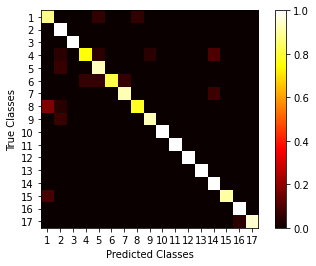

In [20]:
# Display the confusion Matrix
for i in range(17):
  conf_mat[i,:] = conf_mat[i,:]/sum(conf_mat[i,:])

plt.imshow(conf_mat, cmap='hot')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],class_names)
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],class_names)
plt.colorbar()
plt.show()

In [21]:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.axis("off")
    plt.imshow(inp,cmap=plt.cm.binary)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated
    
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()

    for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        #move to GPU
        if CUDA: 
          images, labels = images.cuda(), labels.cuda()
        
        outputs = model(images)
        
        _, preds = torch.max(outputs.data, 1)
       

        for j in range(images.size()[0]):
            # if preds[j] == labels[j]:
            #   continue 
            images_so_far += 1
            #ax = plt.subplot(num_images//2, 2, images_so_far)
  
            #plt.axis('off')
            #ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            print('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(images.cpu().data[j])

            if images_so_far == num_images:
              return

class: 1 predicted: 1


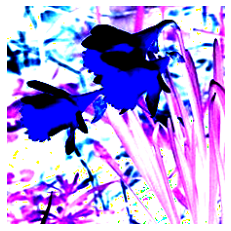

class: 14 predicted: 14


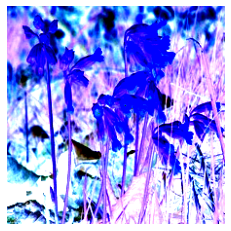

class: 17 predicted: 17


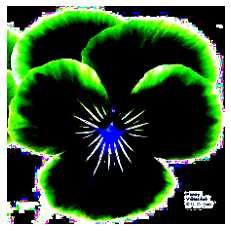

class: 7 predicted: 7


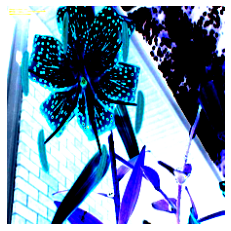

class: 14 predicted: 14


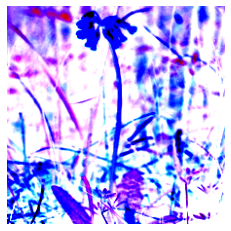

class: 6 predicted: 6


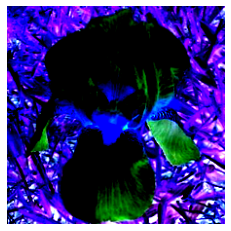

class: 11 predicted: 11


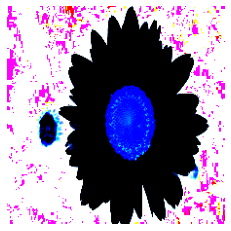

class: 10 predicted: 10


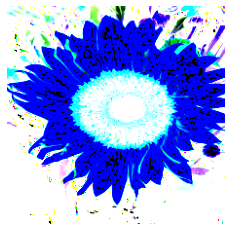

In [22]:
visualize_model(model)

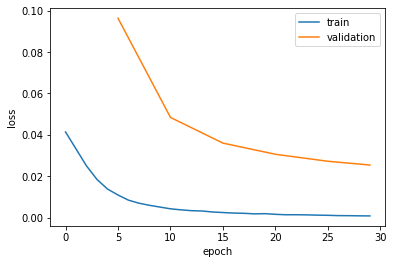

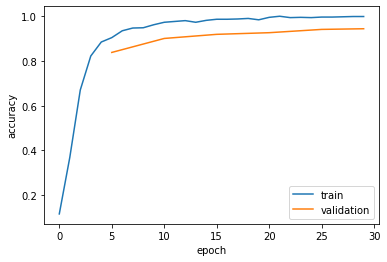

In [23]:
from scipy import interpolate
x = np.arange(5, 30)
x_train = np.arange(0,30)
x1 = [5, 10, 15, 20, 25, 30]
f_loss = interpolate.interp1d(x1, val_loss_list)
f_accuracy = interpolate.interp1d(x1, val_acc_list)


val_acc = f_accuracy(x)   # use interpolation function returned by `interp1d`
val_loss = f_loss(x)

train_loss_list
train_acc_list
val_loss
val_acc


plt.plot(x_train, train_loss_list)
plt.plot(x, val_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()
plt.figure()
plt.plot(x_train, train_acc_list)
plt.plot(x, val_acc)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()